# QF627 Take-Home Assessment

First, you should build a series of trading strategies employing `momentum, mean-reversion, and machine learning approaches`. As you have learned, *within each approach, you could come up with varying strategies* depending on how you define them. Here, think about how you’d like to do this in a more efficient and effective manner, building on what you have learned about Python programming throughout the course.

Second, you should backtest the above trading strategies and come up with accompanying data visualization and evidentiary numerical values (i.e., Sharpe Ratio, compound annual growth rate, maximum drawdown, and how much is left on your account) that allow you to compare if and which of your strategies beat the baseline performance of S&P 500, and by how much.

Third, you should write up an executive summary of your strategies and backtesting results. Please report at least your top three strategies (i.e., strategy A, strategy B, strategy C). In this summary, you should discuss Sharpe Ratio, compound annual growth rate, and maximum drawdown, comparing your results for strategies A, B, and C. For each of the three sections, please provide a bookmark in your Jupyter Notebook file (for easy access).

* [Top 1: Linear Model](#ML)
* [Top 2: AdaBoost](#ML)
* [Top 3: Hybrid Model](#HM)

* [Summary](#summary)


##### You will build your trading strategy using the past 20 years (November 2002 through October 2021) of S&P 500 data (use the SPY ticker for your market baseline return and your strategy return), extracting the data from Yahoo Finance. Your starting capital is set at $500,000.

In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from pandas_datareader import data as pdr
import datetime as dt
import yfinance as yf

np.set_printoptions(precision = 3)
pd.set_option("precision", 3)
pd.set_option("display.float_format", lambda x: "%.3f" % x)
plt.style.use("ggplot")
mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["legend.fontsize"] = 14

%matplotlib inline

In [190]:
SP500 = pdr.get_data_yahoo('SPY', 
                           start = dt.datetime(2002, 11, 1), 
                           end = dt.datetime(2021, 10, 31))
# SP500              

In [228]:
####### Function to summarise Portfolio Returns ########
def portfolio_data(df_, units_bought=6400):
    df=df_.copy()
    
    ### stock_value
    df["STOCK_VALUE"]=df["POSITION"]*df["SPY"]*units_bought
    
    ### cash
    df["ORDERS"]=df["POSITION"].diff(1)*units_bought

    if df["POSITION"].iloc[0]==1:
        df["ORDERS"].iloc[0]=units_bought
        
    df["CASH"]=df["ORDERS"]*df["SPY"]
    df["CASH"]=500000-(df["CASH"].cumsum())
    
    ### portfolio
    df["PORTFOLIO"]=df["CASH"] + df["STOCK_VALUE"]
    
    df.dropna(inplace=True)

    # fig = plt.figure(figsize = (16, 10))
    # sub = fig.add_subplot(111, ylabel = "Value of Our Portfolio")
    # df["PORTFOLIO"].plot(ax = sub, color = "grey", lw = 0.5)
    # plt.show()
    
####### Summary #######
    cash_final= pd.Series(df.iloc[-1]["CASH"], index={"PORTFOLIO"})
    cash_final.name="of which: cash"
    
    cash_initial= 500000-pd.Series(df.iloc[0]["CASH"], index={"PORTFOLIO"})
    cash_initial.name="initial cash invested"
    
    df_s = df[["PORTFOLIO"]]
                    
    portfolio_total=df_s.iloc[-1]
    portfolio_total.name="final portfolio total"
    
    
    df_strat=df[["STRATEGY"]]
    df_strat.rename(columns={"STRATEGY":"PORTFOLIO"},inplace=True)
    D = (df_strat.index[-1] - df_strat.index[0]).days
    CAGR = ((  (np.exp(df_strat.cumsum().iloc[-1])/ np.exp(df_strat.cumsum().iloc[0]))**(365.0/D)  ) - 1)*100
    CAGR.name="CAGR"
    
    cumulative_return=np.exp(df_strat.cumsum())
    final_cumulative_return=cumulative_return.iloc[-1]
    final_cumulative_return.name="cumulative_return"
    
    sharpe=np.sqrt(253) * df_strat.mean(axis=0) / df_strat.std(axis=0)
    # sharpe=np.sqrt(253) * (np.exp(df_strat).pct_change().mean(axis=0) / np.exp(df_strat).pct_change().std(axis=0))
    sharpe.name="Sharpe"
    
    max_drawdown=(cumulative_return.cummax()-cumulative_return).max(axis=0)
    max_drawdown.name="max_drawdown"
    
    summary=pd.DataFrame([cash_initial, portfolio_total, cash_final, final_cumulative_return, CAGR, sharpe, max_drawdown])
    
    return df, summary

# Mean Reversion

In [36]:
SPY1 = SP500.reset_index().copy()
SPY1 = SPY1[["Date", "Adj Close"]].set_index(["Date"])
SPY1 = SPY1.rename(columns = {"Adj Close": "SPY"})
# SPY1

In [78]:
def Test_MR_Strategy(df, fixed_threshold):
    
    if fixed_threshold == 0:
        df["POSITION"] = np.where(df["DISTANCE"] > df["Upper_Threshold"], -1, np.nan)
        df["POSITION"] = np.where(df["DISTANCE"] < df["Lower_Threshold"], 1, df["POSITION"])
        df["POSITION"] = np.where(df["DISTANCE"] * df["DISTANCE"].shift(1) < 0, 
                                0,  df["POSITION"]) 
#         df["POSITION"] = 0
    
        for x in range(len(df)):    
            if df["DISTANCE"].iloc[x] >= (fixed_threshold + 1) * 11: 
                df["POSITION"].iloc[x] = 1
                
                
            elif df["DISTANCE"].iloc[x] <= (fixed_threshold + 1) * -15: 
                df["POSITION"].iloc[x] = -1
                
            elif ((df["DISTANCE"].iloc[x] > (fixed_threshold + 1) * -15) & (df["DISTANCE"].iloc[x] <= (fixed_threshold + 1) * -14)) | ((df["DISTANCE"].iloc[x] >= (fixed_threshold + 1) * 9) & (df["DISTANCE"].iloc[x] <= (fixed_threshold + 1) * 10)): 
                df["POSITION"].iloc[x] = 0
                
    
    else:
        df["POSITION"] = np.where(df["DISTANCE"] > fixed_threshold, -1, np.nan)
        df["POSITION"] = np.where(df["DISTANCE"] < -fixed_threshold, 1, df["POSITION"])
        df["POSITION"] = np.where(df["DISTANCE"] * df["DISTANCE"].shift(1) < 0, 0, df["POSITION"])
        

    df["POSITION"] = df["POSITION"].ffill()
    df["POSITION"] = df["POSITION"].fillna(0)

    df["RETURNS"] = np.log(df.iloc[:, 0]/df.iloc[:, 0].shift(1))
    df["STRATEGY"] = df["POSITION"].shift(1) * df["RETURNS"]
    df[["RETURNS", "STRATEGY"]].dropna().cumsum().apply(np.exp).plot(figsize = (16, 10), grid=True, lw=0.5)
    df[["CUM_STRATEGY"]] = df[["STRATEGY"]].dropna().cumsum().apply(np.exp)
    
    return df

def Mean_Reversion(mr_df, ma_window, fixed_threshold, T_window = 5, dynamic_threshold = 0):
    
    threshold = fixed_threshold
    df = mr_df.copy()
    
    df[f"MA_{ma_window}"] = df.iloc[:, 0].rolling(window = ma_window, center = False).mean()
#     df[f"MA_{ma_window}"] = df.iloc[:, 0].ewm(halflife = 0.85, min_periods = ma_window).mean()
    df["DISTANCE"] = df.iloc[:, 0] - df[f"MA_{ma_window}"]
#     df[["SPY", f"MA_{ma_window}"]].plot(figsize = (16, 10), style = ["grey","r--"], lw = 0.5)
#     df["DISTANCE"].dropna().plot(figsize=(16,10))
    
#     Playing around with threshold
    if dynamic_threshold != 0:
        df["Upper_Threshold"] = dynamic_threshold * df.iloc[:, 0].rolling(window = T_window, min_periods = 1).std()
        df["Lower_Threshold"] = -dynamic_threshold * df.iloc[:, 0].rolling(window = T_window, min_periods = 1).std()
        df["Max_Threshold"] = df.DISTANCE.iloc[:].cummax()
        df["Min_Threshold"] = df.DISTANCE.iloc[:].cummin()
        df.dropna(inplace = True)
        
#         ax = df[["DISTANCE",
#              "Upper_Threshold",
#              "Lower_Threshold",
#                 "Max_Threshold", 
#                 "Min_Threshold"]].plot(figsize = (16, 10), style = ["grey","r--","r--", "k--", "k--"], lw = 0.5)
#         plt.axhline(11, color = "green", ls = "--")
#         plt.axhline(0, color = "green", ls = "--")
#         plt.axhline(-15, color = "green", ls = "--")
#         plt.axhline(10, color = "orange", ls = "--")
#         plt.axhline(-14, color = "orange", ls = "--")

#     else: 
#         df["DISTANCE"].dropna().plot(figsize = (16,10))
#         plt.axhline(threshold, color = "green", ls = "--")
#         plt.axhline(0, color = "green", ls = "--")
#         plt.axhline(-threshold, color = "green", ls = "--")
    
    df = Test_MR_Strategy(df, threshold)
    
    return df



##### Functions to find the best thresholds and moving windows 

In [74]:
def finding_best_fixed_threshold(test_df, max_T, max_W):    
    strat = pd.DataFrame({'T': [0], 'W': [0], 'strat_ret': [0]})
    for t in np.arange(2, max_T+1, 1):
        for w in np.arange(5, max_W+5, 5):
            row = pd.DataFrame({'T': [t], 'W': [w], 'strat_ret': [0]})
            df = pd.DataFrame()
            df = Mean_Reversion(test_df, w, t)
            row[["strat_ret"]] = df.CUM_STRATEGY.iloc[-1]
            strat = pd.concat([strat, row], ignore_index=True)
    #         print("For Fixed Threshold = %d and SMA Window = %d, Strategy Returns = %.3f" %(t, w, df.CUM_STRATEGY.iloc[-1]))
    strat_ret_max = strat.strat_ret.max()
    
    return strat[strat.strat_ret == strat_ret_max]

def finding_best_dynamic_threshold(test_df, max_T, max_MW, max_TW):    
    strat = pd.DataFrame({'T': [0], 'MW': [0], 'TW': [0], 'strat_ret': [0]})
    
    for t in np.arange(1, max_T+0.1, 0.1):
        for mw in np.arange(3, max_MW+2, 2):
            for tw in np.arange(3, max_TW+2, 2):
                row = pd.DataFrame({'T': [t], 'MW': [mw], 'TW': [tw], 'strat_ret': [0]})
                df = pd.DataFrame()
                df = Mean_Reversion(test_df, mw, 0, tw, t)
                row[["strat_ret"]] = df.CUM_STRATEGY.iloc[-1]
                strat = pd.concat([strat, row], ignore_index=True)
                
    strat_ret_max = strat.strat_ret.max()
    
    return strat[strat.strat_ret == strat_ret_max]

In [75]:
# finding_best_fixed_threshold(df, 10, 200)

,T,W,strat_ret
1,2,5,2.041


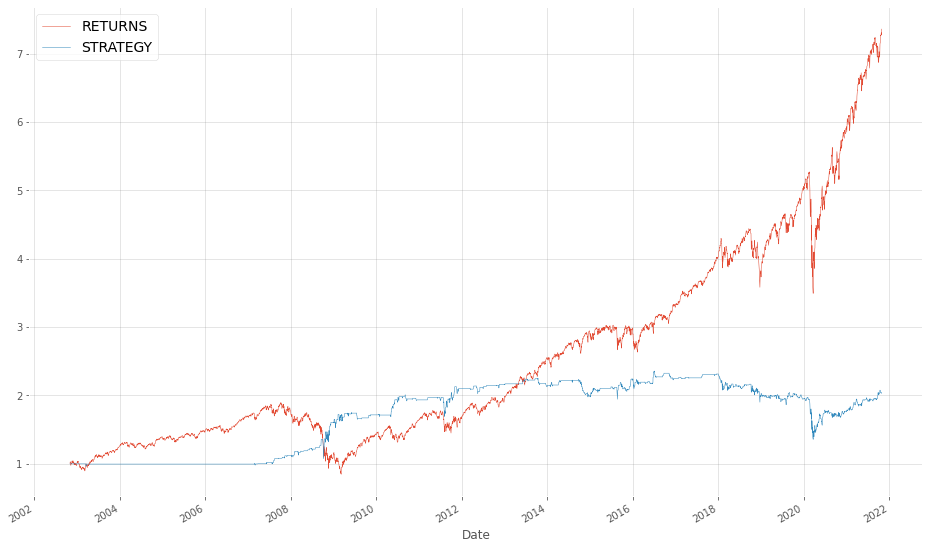

In [89]:
# Using the threshold = 2 and window = 5 values above that give the best final cumulative returns
df = SPY1.copy()
fixed_mr = Mean_Reversion(df, 5, 2)

In [1]:
# finding_best_dynamic_threshold(df, 3, 50, 50)

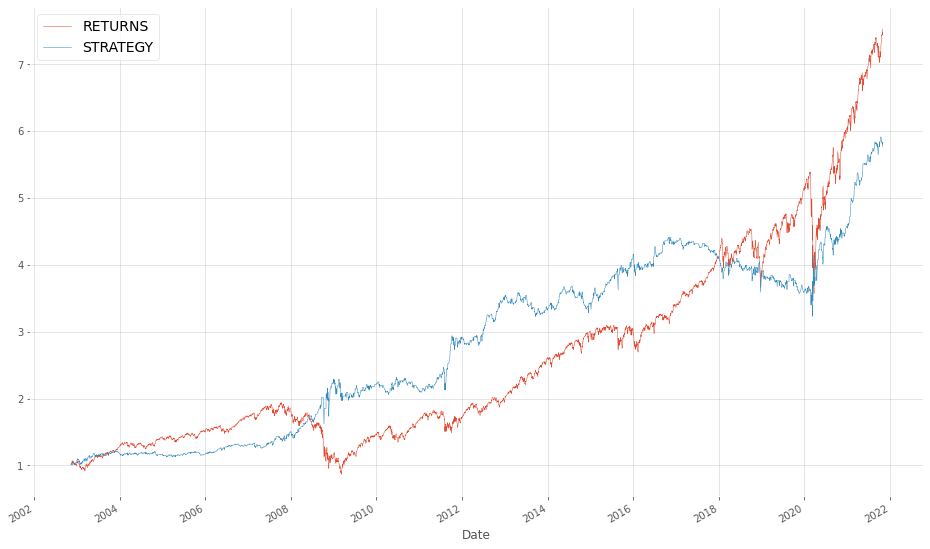

In [208]:
# Using the threshold factor = 1.3, sma_window = 5 and std_window = 5 values above that give the best final cumulative returns
df = SPY1.copy()
dynamic_MR = Mean_Reversion(df, 7, 0, 5, 1.3)

> Mean reversion strategy is based on the idea that extreme changes in prices will revert to its mean over time. We use a threshold to determine whether to buy or sell a security.We give a buy signal when for the security when the distance between its price and its SMA crosses the lower threshold and a sell signal is privided when the distance crosses the upper threshold.

> In our code we have tried to calculate the optimum combination of the threshold multiplier(T) ,threshold measured in terms of SMA standard deviation(TW) and SMA window(MW) to get the best cumulative returns. For (T) we took a range from 1 to 2. For (TW) and (MW) we took a range from 1 to 50. 

> The optimal result was found when T= 1.3 , MW = 7, TW = 5 where the cumulative return equals 5.869871. Even though our strategy's cumulative return in lower than the cumulative return of SPY we see that when our strategy performed better when the trends were consistent for longer periods of time like from 2009 to 2018.  

> By changing from a fixed threshold to a dynamic thresholds (1.3 * standard deviation moving window), our group is able to improve the performance of the Mean Reversion Strategy to a large extent.   

> In additional, we also enhanced the vanilla Mean Reversion (MR) strategy by accounting for big spikes or dips in the SPY price. This was done by including fixed thresholds of 11 (sharp spikes) and -15 (sharp dips) on top of the dynamic standard deviation moving window thresholds . In the event when distance exceeds these fixed thresholds, our strategy will take a long position when it exceeds the upper bound and take a short position when it exceeds the lower bound. This allows us to take advantage of sudden sharp price movements, particularly sharp downside dips, to short the market temporarily as it continues to dip further and at the same time, protect us from the usual MR strategy that will take a long position when price goes below the support level.

> Cumulative strategy returns improved significantly from around 2% to 6%.
 

# Moving Average

In [112]:
def Test_MA_Strategy(df, lag):
    
    df["Buy_or_Sell"] = np.where(df["SHORTER_MA"] > df["LONGER_MA"],
                                1, 0)
    df["POSITION"] = 0

    # Strategy here is to make sure that trend continues for at least 3 days for me to take position
    if (lag != 0) & (lag <= 3):
        
        for i in np.arange(1, lag+1):        
            df[f"momentum_{i}"] = df["Buy_or_Sell"].diff(i) 

        for x in range(len(df)):    
            if (df.Buy_or_Sell.iloc[x] == 1) & (df["momentum_1"].iloc[x] == 0) & (df["momentum_1"].iloc[x] == df["momentum_2"].iloc[x]) & (df["momentum_1"].iloc[x] == df["momentum_3"].iloc[x]):
                df["POSITION"].iloc[x] = 1        
            elif (df.Buy_or_Sell.iloc[x] == 0) & (df["momentum_1"].iloc[x] == 0) & (df["momentum_1"].iloc[x] == df["momentum_2"].iloc[x]) & (df["momentum_1"].iloc[x] == df["momentum_3"].iloc[x]):
                df["POSITION"].iloc[x] = -1 
            else:
                df["POSITION"].iloc[x] = 0
                             
    else:
        # df["POSITION"] = df["Buy_or_Sell"].diff()
        df["POSITION"] = np.where(df["SHORTER_MA"] < df["LONGER_MA"],
                            -1, 1)
    
    df["RETURNS"] = np.log(df.iloc[:, 0] / df.iloc[:, 0].shift(1))
    df["STRATEGY"] = df["POSITION"].shift(1) * df["RETURNS"]

    df[["RETURNS", "STRATEGY"]].dropna().cumsum().apply(np.exp).plot(figsize = (16,10), style = ["g--", "r--"], lw = 0.75, grid = True)
    
    return df

def Moving_Average(ma_df, short_win, long_win, lag = 0, kind = "sma"):
    df = ma_df.copy()
    
    if kind.lower() == "sma":
        df["SHORTER_MA"] = df.iloc[:, 0].rolling(window = short_win, center = False).mean()
        df["LONGER_MA"] = df.iloc[:, 0].rolling(window = long_win, center = False).mean()
        df.dropna(inplace = True)

        # ax = df[["SHORTER_MA", "LONGER_MA"]].iloc[-500:].plot(figsize = (16, 8), style = ["g--", "r--"], lw = 0.75)
        # df.iloc[-500:, 0].plot(ax = ax, lw = 2)

    elif kind.lower() == "ewma":
        # Using EWMA for short term MA because it takes into account recent spikes/dips more
        df["SHORTER_MA"] = df.iloc[:, 0].ewm(halflife = 0.94, min_periods = 50).mean()
        # df["SHORTER_MA"] = df.iloc[:, 0].ewm(halflife = 0.005, min_periods = 200).mean()
        df["LONGER_MA"] = df.iloc[:, 0].rolling(window = long_win, center = False).mean()
        df.dropna(inplace = True)

        # ax = df[["SHORTER_MA", "LONGER_MA"]].iloc[-100:].plot(figsize = (16, 8), style = ["g--", "r--"], lw = 0.75)
        # df.iloc[-100:, 0].plot(ax = ax, lw = 2)     
        
    df = Test_MA_Strategy(df, lag)

    # when finding best windows combi
    # fig,ax= plt.subplots(1, figsize=(16,10))
    # df[["RETURNS", "STRATEGY"]].dropna().cumsum().apply(np.exp).plot(style = ["g--", "r--"], lw = 0.75, ax=ax)
    # ax.title.set_text(f"strategy_{short_win}_{long_win}") 

    return df

/shared-libs/python3.7/py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/shared-libs/python3.7/py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/shared-libs/python3.7/py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

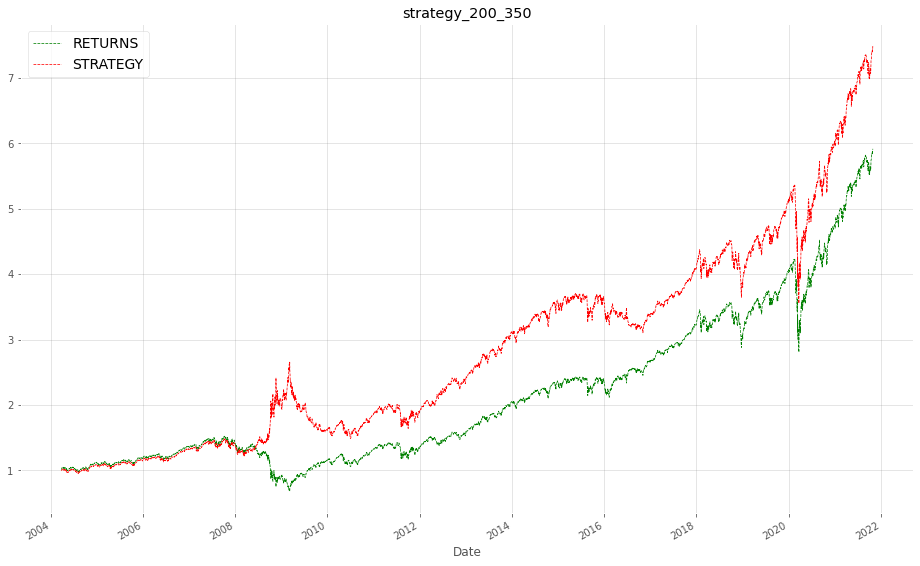

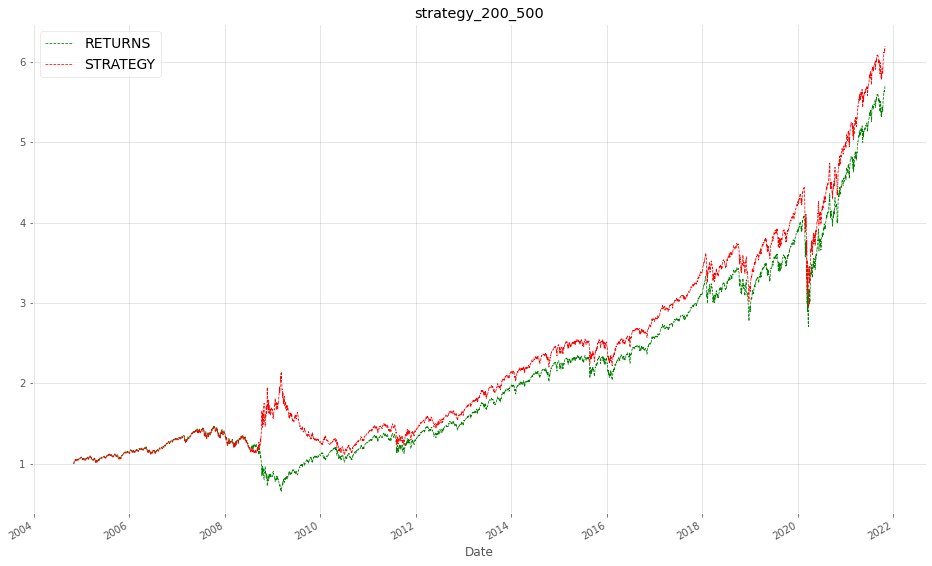

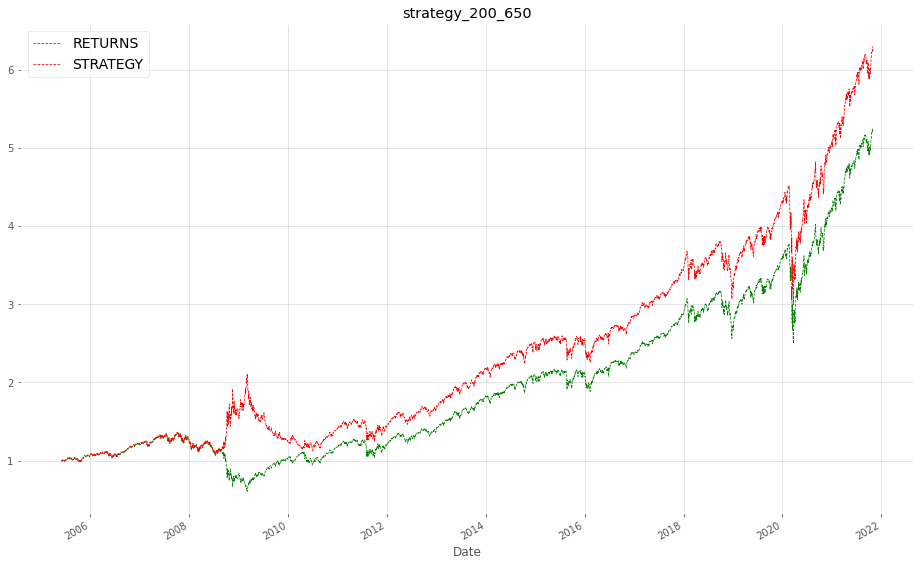

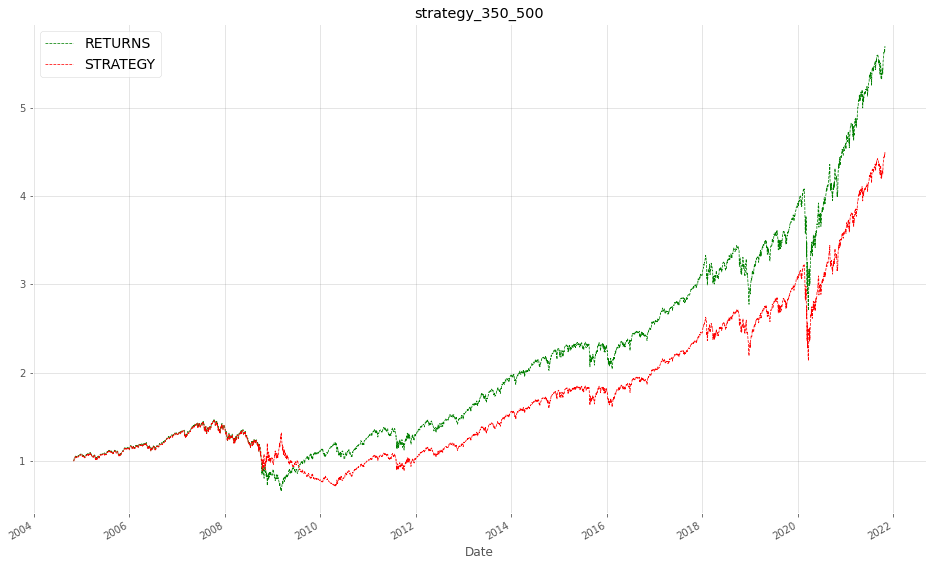

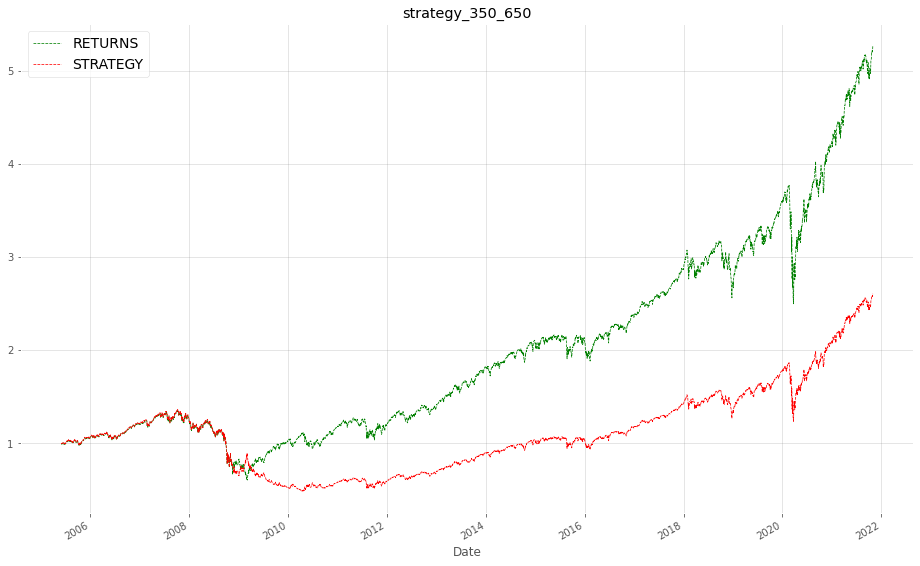

In [111]:
# Finding the best combination of short and long moving average windows
# Testing_DF = SPY1.copy()

# d = {}
# for i in range(200,500,150):
#     for j in range (i+150,800,150):
#         d[f"{i}_{j}"] = Moving_Average(Testing_DF, i, j, 3, "sma")

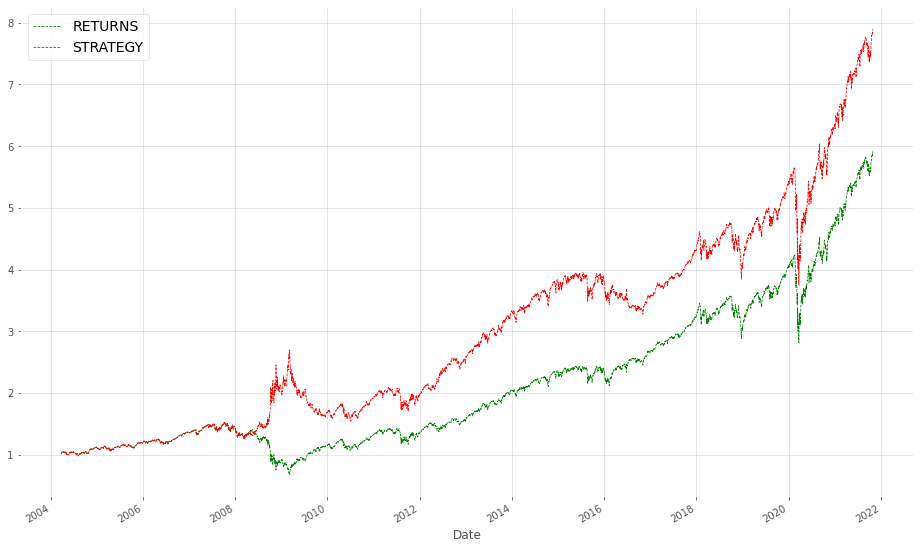

In [212]:
# Simple Moving Average
df = SPY1.copy()
simple_ma = Moving_Average(df, 200, 350, 0)

/shared-libs/python3.7/py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


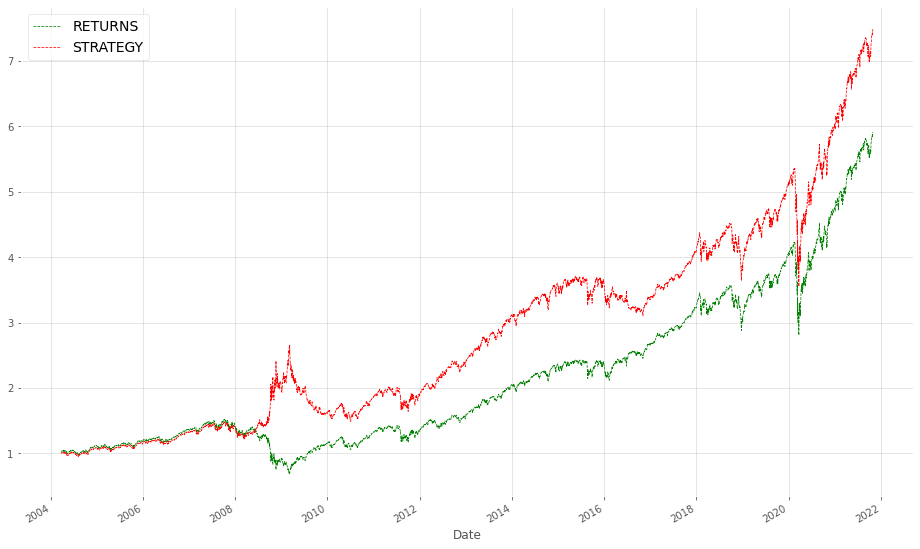

In [157]:
# Simple Moving Average but included previous 3 days momentum into consideration
df = SPY1.copy()
simple_ma_momentum = Moving_Average(df, 200, 350, 3)

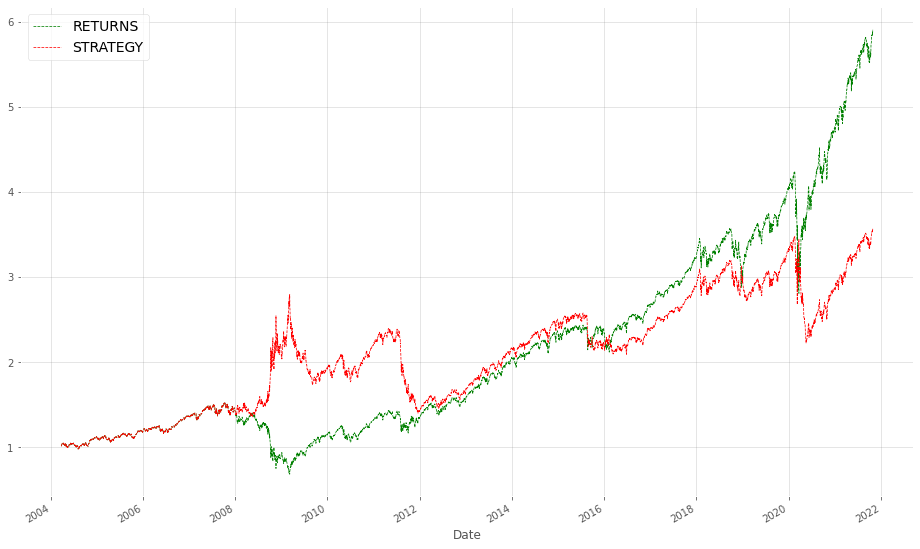

In [213]:
# Exponential Moving Average (used a halflife of 0.94) as the short term moving average and simple moving average of 350 for long term
df = SPY1.copy()
exp_ma = Moving_Average(df, 200, 350, 0, "ewma")

> Momentum strategy is based on the idea that the investor buys when securities when they are in an uptrend and short sells them when they are in a downtrend. According to this, we buy a security when the SMA crosses the LMA and sell it when the LMA crosses the SMA.  

> For Moving Average strategy, we ran an loop of shorter window and longer window to find the combination to give us the best performance. The best combination is found to be 200 and 350 for short moving window and long moving window respectively.

> From the 3 graphs above where we have 2 Simple Moving Average graphs, it can be observed that by including previous 3 days momentum did not improve the cumulative returns.  

> Also, by using Exponential Moving Average as the short term moving average does not improve or give favourable cumulative returns too.  

> Hence, our group will use the Simple Moving Average (without including previous 3 days momentum)

<a id="LM"></a>
<a id="AB"></a>
<a id="HM"></a>

<a id="HM"></a>
## Hybrid Model (Momentum + Mean Reversion)

- For the Hybrid Strategy, our group will make use of both the Simple Moving Average (SMA) and Mean Reversion (MR) strategies to take positions
- It will use the best combination of 200 and 350 moving average windows for the SMA and the best parameter values obtained above for MR. (i.e. mean window = 7, std window = 5, dynamic_threshold = 1.3)
- The purpose of the hybrid strategy is to further enhance MR strategy proposed above that takes care/advantage of sharp downside dips. By including SMA, we are able to identify short term momentum and thus oppotunities. 

- The Hybrid strategy is designed to use SMA whenever there is an upward momentum (taking a long position) and take a short position when the difference between the Long MA and Short MA is increasingly decreasing for the past 3 days. Else, we will take position according to the enhanced MR strategy.



In [214]:
def hybrid(hybrid_df, short_ma = 200, long_ma = 350, mr_window = 7, fixed_threshold = 0, T_window = 5, dynamic_threshold = 1.3):
    
    df = hybrid_df.copy()
    
#     Moving Average Part
    df["SHORTER_MA"] = df.iloc[:, 0].rolling(window = short_ma, center = False).mean()
    df["LONGER_MA"] = df.iloc[:, 0].rolling(window = long_ma, center = False).mean()
    df.dropna(inplace = True)
    df["DISTANCE_MA_T3"] = df["SHORTER_MA"] - df["LONGER_MA"]
    df["DISTANCE_MA_T2"] = df["DISTANCE_MA_T3"].diff(1)
    df["DISTANCE_MA_T1"] = df["DISTANCE_MA_T2"].diff(1)
    df["DISTANCE_MA_T0"] = df["DISTANCE_MA_T1"].diff(1)
    df.dropna(inplace = True)
    
#     Mean Reversion Part
    df[f"MR_{mr_window}"] = df.iloc[:, 0].rolling(window = mr_window, center = False).mean()
    df["DISTANCE"] = df.iloc[:, 0] - df[f"MR_{mr_window}"]
    df["Upper_Threshold"] = dynamic_threshold * df.iloc[:, 0].rolling(window = T_window, min_periods = 1).std()
    df["Lower_Threshold"] = -dynamic_threshold * df.iloc[:, 0].rolling(window = T_window, min_periods = 1).std()
    df.dropna(inplace = True)

#     Use Moving Average when there is an upside opportunity
    df["Buy_or_Sell"] = np.where(df["SHORTER_MA"] > df["LONGER_MA"], 1, 0)
    
    # Set up Mean Reversion Position
    df["POSITION"] = np.where(df["DISTANCE"] > df["Upper_Threshold"], -1, np.nan)
    df["POSITION"] = np.where(df["DISTANCE"] < df["Lower_Threshold"], 1, df["POSITION"])
    df["POSITION"] = np.where(df["DISTANCE"] * df["DISTANCE"].shift(1) < 0, 0,  df["POSITION"]) 
    
    for x in range(len(df)): 
        if df["Buy_or_Sell"].iloc[x] != 1:
            if df["DISTANCE"].iloc[x] >= (fixed_threshold + 1) * 11: 
                df["POSITION"].iloc[x] = 1
                
                
            elif df["DISTANCE"].iloc[x] <= (fixed_threshold + 1) * -15: 
                df["POSITION"].iloc[x] = -1
                
            elif ((df["DISTANCE"].iloc[x] > (fixed_threshold + 1) * -15) & (df["DISTANCE"].iloc[x] <= (fixed_threshold + 1) * -14)) | ((df["DISTANCE"].iloc[x] >= (fixed_threshold + 1) * 9) & (df["DISTANCE"].iloc[x] <= (fixed_threshold + 1) * 10)): 
                df["POSITION"].iloc[x] = 0
#             Shorting when there is a dip using Moving Average (Momentum from past 3 days)    
            elif (df["DISTANCE_MA_T3"].iloc[x] < 1*df["DISTANCE_MA_T2"].iloc[x]) & (df["DISTANCE_MA_T2"].iloc[x] < 1*df["DISTANCE_MA_T1"].iloc[x]) & (df["DISTANCE_MA_T1"].iloc[x] < df["DISTANCE_MA_T0"].iloc[x]):
                df["POSITION"].iloc[x] = -1
                
        else:
#             df["POSITION"].iloc[x] = 1
            
#             Giving a bit of tolerance (Just want to make sure that there is still some upward momentum)
            if df["DISTANCE_MA_T3"].iloc[x] >= 0.9*df["DISTANCE_MA_T2"].iloc[x]:
                df["POSITION"].iloc[x] = 1            
            else:
                df["POSITION"].iloc[x] = 0
                    
                    
    df["POSITION"] = df["POSITION"].ffill()
    df["POSITION"] = df["POSITION"].fillna(0)
    
    df["RETURNS"] = np.log(df.iloc[:, 0] / df.iloc[:, 0].shift(1))
    df["STRATEGY"] = df["POSITION"].shift(1) * df["RETURNS"]

    df[["RETURNS", "STRATEGY"]].dropna().cumsum().apply(np.exp).plot(figsize = (16,10), lw = 0.5, grid=True)  

    return df

/shared-libs/python3.7/py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


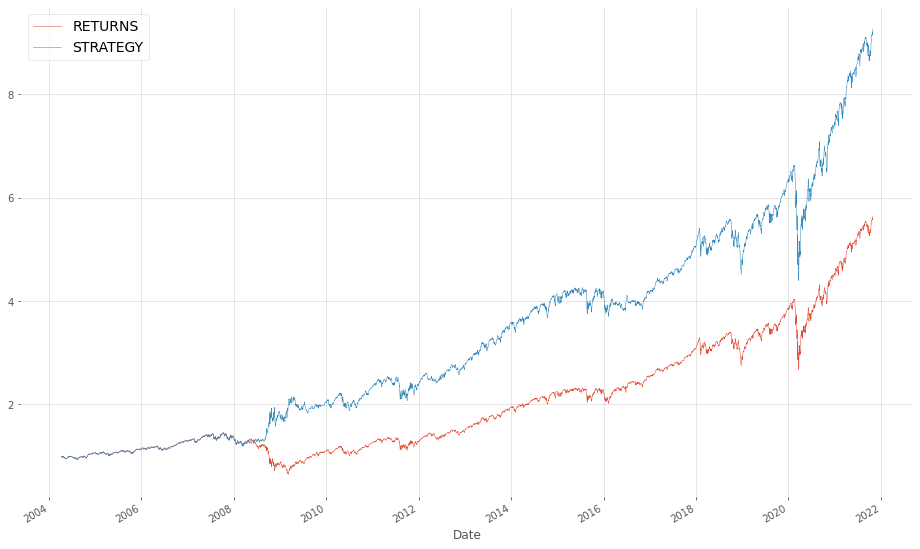

In [215]:
df = SPY1.copy()
hybrid_mr_ma = hybrid(df)

> It can be observed that the Hybrid Strategy is able to yield better cumulative strategy returns when compared to individual SMA and MR strageies as it overcomes the shortcomings each other.

> It improved Cumulative Strategy Returns signicantly from around 6% in MR to about 9%.

<a id="ML"></a>
## Machine Learning

> We used machine learning algorithms - a linear regression model and an ensemble model(ADA Boost regressor) to predict the direction of the market based on lagged returns. We then formulated a strategy based on the predictions. Specifically, when the market direction is predicted to trend up, we took a long position, and vice versa.

> To optimise our model, we implemented a loop function for different lags and identified the lag which provided the highest portfolio return. Based on the results of the optimisation, we used a lag of 5 days for the machine learning algorithms.

>Overall, the linear regression model and ensemble model allowed us to earn a cumulative return of 15.6% and 14.2% respectively.


In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pandas_datareader import data as pdr
import datetime as dt

pd.set_option("precision", 3)
pd.set_option("display.float_format", lambda x: "%.3f" % x)

In [82]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import AdaBoostRegressor

from sklearn.metrics import accuracy_score
from sklearn import linear_model

In [83]:
start = dt.date(2002, 11, 1)
end = dt.date(2021, 10, 31)
tickers = ["SPY"]

def extract_data(tickers, start, end):
    
    def data(ticker):
        return pdr.DataReader(ticker, "yahoo", start, end).dropna() 
    
    stocks = map(data, tickers)
    
    return pd.concat(stocks, keys = tickers, names = ["Ticker", "Date"])

In [84]:
SPY = extract_data(tickers, start, end)
mldata = (SPY.reset_index().pivot("Date", "Ticker", "Adj Close")).copy()

In [85]:
####### function to implement ML model ########
def ml(model_ml, lags):
    
    xcols=[]
   
    model=model_ml
    df=mldata[["SPY"]].copy()
    df["RETURNS"]=np.log(df["SPY"]/df["SPY"].shift(1))
    
    for i in range(1,lags+1):
        df[f"RETURNS_lag{i}"]=df["RETURNS"].shift(i)
        df.dropna(inplace=True)
        xcols.append(f"RETURNS_lag{i}")

    x=df[xcols]
    y=np.sign(df["RETURNS"])
    
    ### positions
    model.fit(x,y)
    df["POSITION"]=np.sign(model.predict(x))
    
    ### strategy
    df["STRATEGY"]=df["POSITION"]*df["RETURNS"]
    
    fig,ax= plt.subplots(1, figsize=(16,10))
    df[["RETURNS", "STRATEGY"]].dropna().cumsum().apply(np.exp).plot(style = ["g--", "r--"], lw = 0.75, ax=ax)
    ax.title.set_text(f"STRATEGY_lag{lags}")
    
    return df

In [86]:
####### function to find ideal lags ########
def loops (lrange, urange, steps, model_ml):
    d2={}
    for i in range (lrange, urange, steps):
        d2[f"STRATEGY_lag{i}"]=ml(model_ml, i)
    return d2

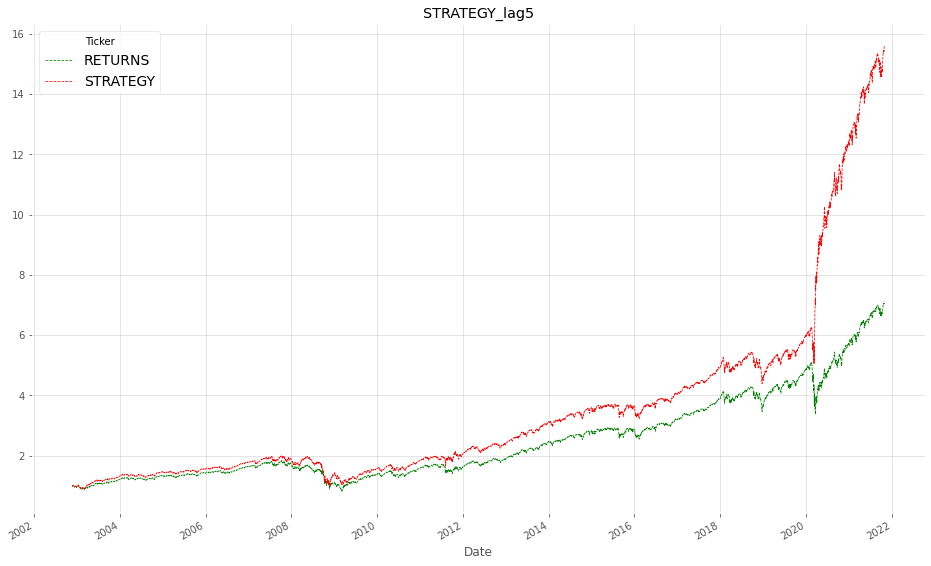

In [187]:
LM=loops(5,10,5,linear_model.LogisticRegression(solver = "lbfgs",
                                    C = 1e7,
                                    multi_class = "auto",
                                    max_iter = 1000))

In [186]:
df_LM,summary_LM=portfolio_data(LM["STRATEGY_lag5"], 6400)
summary_LM

/shared-libs/python3.7/py/lib/python3.7/site-packages/pandas/core/frame.py:4449: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,PORTFOLIO
initial cash invested,413649.365
final portfolio total,3256606.738
of which: cash,317406.738
cumulative_return,15.590
CAGR,15.602
Sharpe,0.771
max_drawdown,1.186


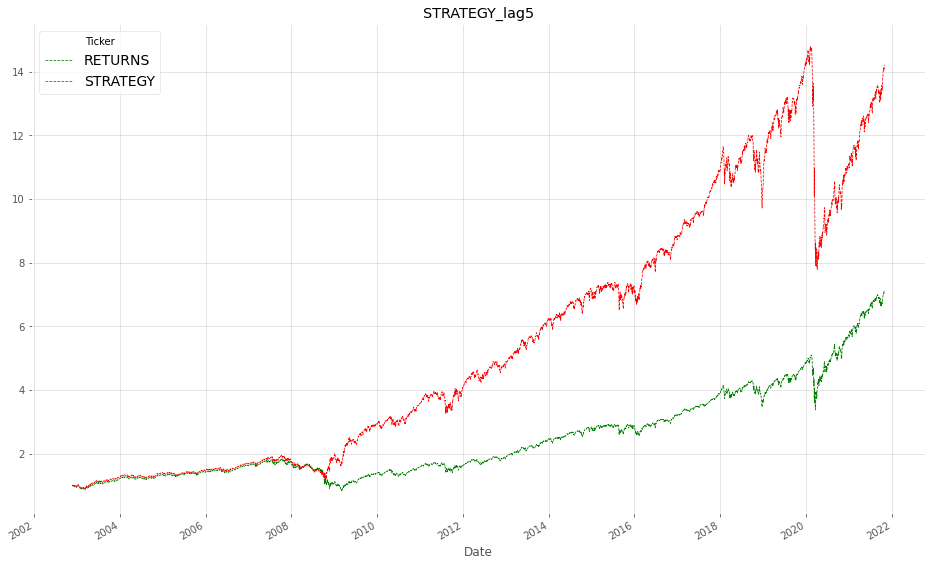

In [209]:
ADA=loops(5,10,5,AdaBoostRegressor())

In [210]:
df_ADA,summary_ADA=portfolio_data(ADA["STRATEGY_lag5"], 6400)
summary_ADA

/shared-libs/python3.7/py/lib/python3.7/site-packages/pandas/core/frame.py:4449: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,PORTFOLIO
initial cash invested,413649.365
final portfolio total,3218737.598
of which: cash,279537.598
cumulative_return,14.212
CAGR,15.039
Sharpe,0.745
max_drawdown,7.021


<a id="summary"></a>
## Summary

Based on our results,the best performing strategies were the two machine learning algorithm based models (linear regression and ADA Boost), followed by the hybrid model. Using these strategies, we managed to outperform the S&P with a cumulative return of between 9.26% and 15.6% (S&P cumulative return was about 7%)

CAGR refers to the mean annual growth rate of an investment over a specified period of time. We note that our CAGR of 13.5% to 15.6% is better than that typically expected for investments for large cap companies (5 to 10%). 

The Sharpe Ratio measures  return per unit of standard deviation(risk) Our strategies achieved a Sharpe Ratio of between 0.68 to 0.77. While positive, we note that a Sharpe ratio of less than 1 could indicate that we may be taking on excess risk per unit of return, and that there could be room to further improve our strategies.

A maximum drawdown is the maximum observed loss from a peak to a trough of a portfolio, before a new peak is attained. We note that a low maximum drawdown is preferred as this indicates that losses from investment were small. While our strategies' max drawdown were relatively high, we note that these could be because the strategies were based on the index, for which there were some degree of fluctuations, particularly around year 2020. Nonetheless, our portfolio returns recovered well and ultimately outperformed the S&P.

### From the summary table, the top 3 strategies are:

1) Linear Model (Logistic Regression)
2) ADABoost
3) Hybrid Model

In [221]:
summary_table = pd.DataFrame()

portfolio_MR, MR = portfolio_data(dynamic_MR)
MR.rename(columns = {"PORTFOLIO": "MR"}, inplace=True)

portfolio_SMA, SMA = portfolio_data(simple_ma)
SMA.rename(columns = {"PORTFOLIO": "SMA"}, inplace=True)

portfolio_EWMA, EWMA = portfolio_data(exp_ma)
EWMA.rename(columns = {"PORTFOLIO": "EWMA"}, inplace=True)

portfolio_HYBRID, HYBRID = portfolio_data(hybrid_mr_ma)
HYBRID.rename(columns = {"PORTFOLIO": "HYBRID"}, inplace=True)

summary_LM.rename(columns = {"PORTFOLIO": "LM"}, inplace=True)

summary_ADA.rename(columns = {"PORTFOLIO": "ADA"}, inplace=True)

pd.concat([summary_table, MR, SMA, EWMA, HYBRID, summary_LM, summary_ADA], axis = 1)

/shared-libs/python3.7/py/lib/python3.7/site-packages/pandas/core/frame.py:4449: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/shared-libs/python3.7/py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/shared-libs/python3.7/py/lib/python3.7/site-packages/pandas/core/frame.py:4449: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

,MR,SMA,EWMA,HYBRID,LM,ADA
initial cash invested,390550.586,496820.312,496820.312,521083.203,413649.365,413649.365
final portfolio total,2188778.101,3015083.203,2091243.164,3109464.551,3256606.738,3218737.598
of which: cash,5127978.101,75883.203,-847956.836,170264.551,317406.738,279537.598
cumulative_return,5.763,7.897,3.575,9.265,15.590,14.212
CAGR,9.624,12.369,7.424,13.522,15.602,15.039
Sharpe,0.620,0.618,0.381,0.688,0.771,0.745
max_drawdown,1.180,1.907,1.397,2.237,1.186,7.021


### Account Balance

#### Top 1: Linear Model

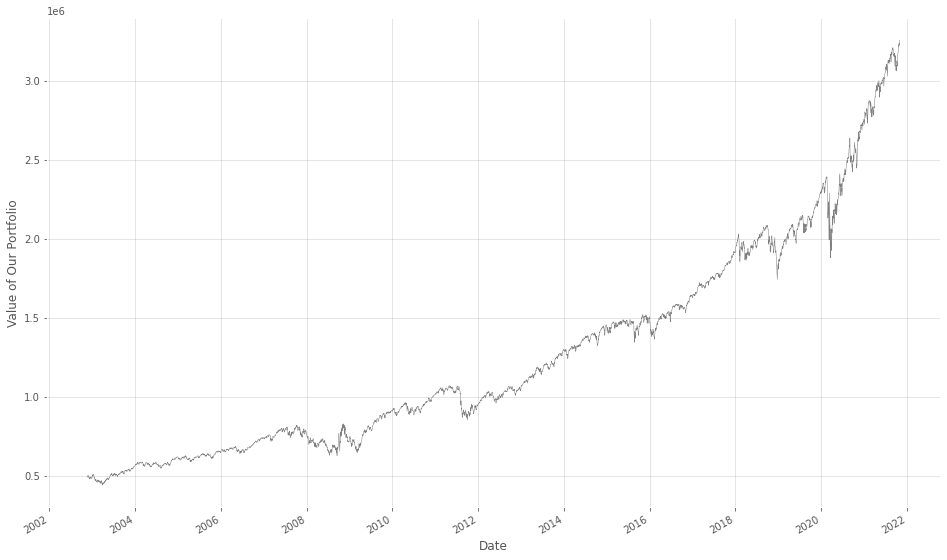

/shared-libs/python3.7/py/lib/python3.7/site-packages/pandas/core/frame.py:4449: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [225]:
portfolio_data(LM["STRATEGY_lag5"])

#### Top 2: AdaBoost

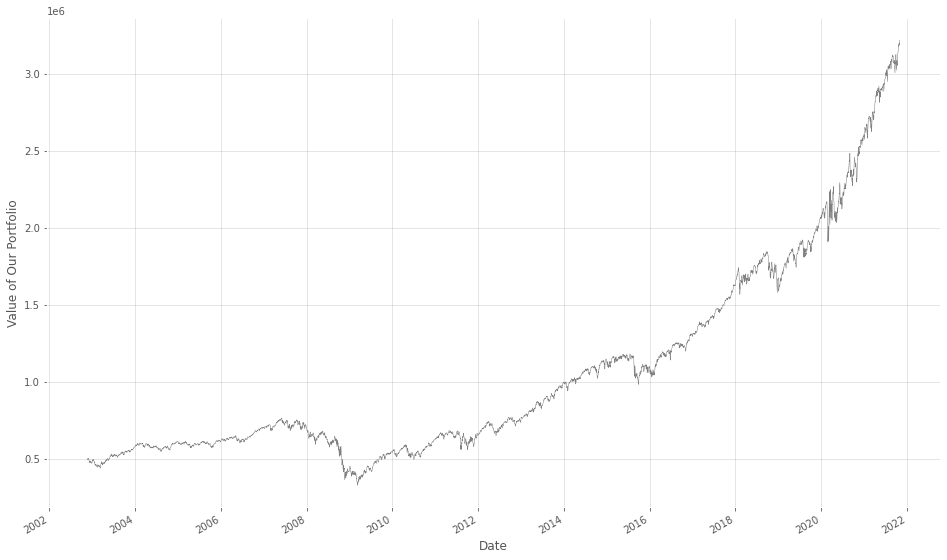

/shared-libs/python3.7/py/lib/python3.7/site-packages/pandas/core/frame.py:4449: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [226]:
portfolio_data(ADA["STRATEGY_lag5"])

#### Top 3: Hybrid Model

/shared-libs/python3.7/py/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


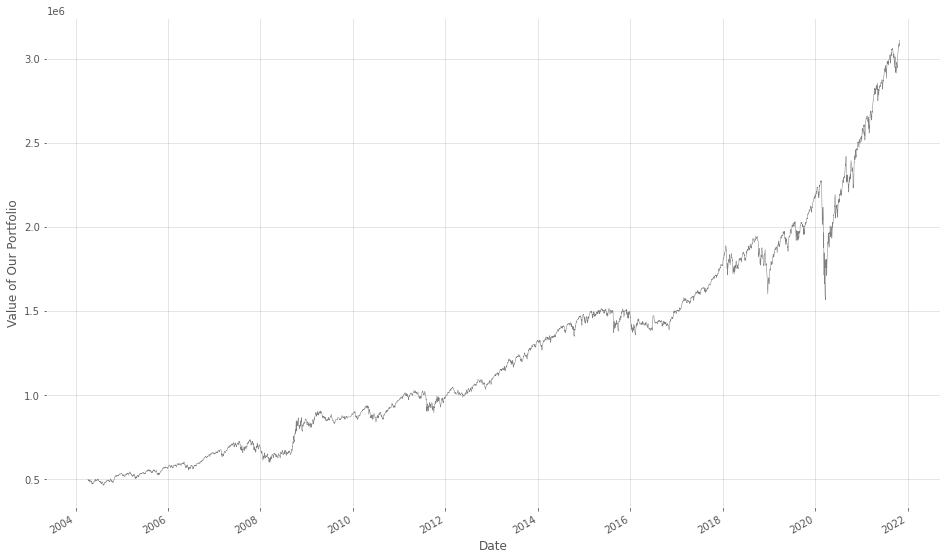

/shared-libs/python3.7/py/lib/python3.7/site-packages/pandas/core/frame.py:4449: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [227]:
portfolio_data(hybrid_mr_ma)